In [2]:
import random
import torch

from utils.Logger import showPlot
from utils.Timer import asMinutes, timeSince

%load_ext autoreload
from data.exampleJP_Data import Lang, prepareData
from model.rnn_model.encoderRNN import EncoderGRU, EncoderLSTM
from model.rnn_model.decoderRNN import (
    DecoderGRU, DecoderLSTM, 
    AttnDecoderGRU, AttnDecoderLSTM1, AttnDecoderLSTM2
)
from model.seq2seq_Model import (
    Seq2Seq_batch_ptModel, 
    Seq2SeqTranslate_ptTokenizer,
)
from baselineJP_ExpTrain import example_ExpTrain
from baseline_ExpEval import evaluate_batch_randomly
%autoreload


DATA_DIR = '_data_example'

## get data

In [3]:
# if True:    # 解凍する場合は True に書き換え
#     !mkdir  $DATA_DIR
#     %cd  $DATA_DIR

#     !git clone https://github.com/odashi/small_parallel_enja
#     !echo '------------------'
#     !head -n 5 small_parallel_enja/train.en
#     !head -n 5 small_parallel_enja/train.ja
#     !echo '------------------'

#     !ls
#     %cd ../

## setup Experiment

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## setup Data

In [5]:
input_lang, output_lang, pairs = prepareData(
    'en', 'ja', f'{DATA_DIR}/small_parallel_enja', False)

Reading lines...
Read 50000 sentence pairs
Counting words...
Counted words:
en 6637
ja 8777


In [6]:
print(random.choice(pairs))
print(input_lang.n_words, output_lang.n_words)

["yes , i 'll be right there .", 'わか っ た わ 。 すぐ 行 く から 待 っ て て ね 。']
6637 8777


In [7]:
# train / test split
from sklearn.model_selection import train_test_split
train_pairs, test_pairs = train_test_split(pairs, test_size=0.2)

## setup Model

In [8]:
## Model
tokenizer = Seq2SeqTranslate_ptTokenizer(
                    input_lang, output_lang, device)

## setup Model

In [9]:
%load_ext autoreload
from model.rnn_model.decoderRNN import (
    DecoderGRU, DecoderLSTM, 
    AttnDecoderGRU, AttnDecoderLSTM1, AttnDecoderLSTM2
)
from model.seq2seq_Model import (
    Seq2Seq_batch_ptModel, 
    Seq2SeqTranslate_ptTokenizer,
)
from baselineJP_ExpTrain import example_ExpTrain
from baseline_ExpEval import evaluate_batch_randomly
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
load_model_dir = '_best_weight' if torch.cuda.is_available() else "_best_weight_CPU"

In [11]:
emb_size = 1024
hidden_size = 1024

encoder = EncoderLSTM(input_lang.n_words, emb_size, hidden_size)
encoder.load_weights(
            load_m_dir=f'_logs/{load_model_dir}', 
            load_m_file_name='encoder.pth')

[info] encoder.pth loaded !


## exec Evaluate

In [12]:
MAX_LENGTH = 18

decoder1 = AttnDecoderLSTM1(
                emb_size, hidden_size, output_lang.n_words, device)
decoder1.load_weights(
            load_m_dir=f'_logs/{load_model_dir}', 
            load_m_file_name='decoder_LSTM1.pth')

seq2seq_lstm1_model = Seq2Seq_batch_ptModel(
                            tokenizer, device,
                            dropout_p=0.1, max_length=MAX_LENGTH,
                            save_m_dir='_logs', 
                            save_m_file_names=(
                                'encoder.pth', 'decoder_LSTM1.pth'))
seq2seq_lstm1_model.set_models(encoder, decoder1)

[info] decoder_LSTM1.pth loaded !


> the accident took place at that corner .
= その 事故 は 、 その 角 で 起き た 。
< 彼 は は は い 。 <EOS>
bleu: 7.107197028258987e-232

/Users/m_ryo/.pyenv/versions/3.8.4/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/m_ryo/.pyenv/versions/3.8.4/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/m_ryo/.pyenv/versions/3.8.4/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
T

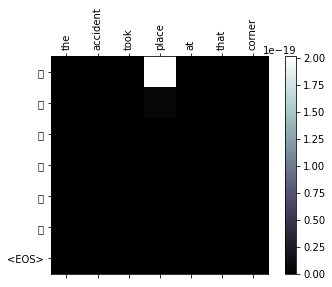

> there is nothing wrong with him .
= 彼 は 何処 も 悪 く な い 。
< 私 は は の の い 。 <EOS>
bleu: 5.795035077445241e-155

/Users/m_ryo/.pyenv/versions/3.8.4/lib/python3.8/site-packages/matplotlib/textpath.py:84: RuntimeWarning: Glyph 31169 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/Users/m_ryo/.pyenv/versions/3.8.4/lib/python3.8/site-packages/matplotlib/textpath.py:84: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/Users/m_ryo/.pyenv/versions/3.8.4/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 31169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/m_ryo/.pyenv/versions/3.8.4/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/m_ryo/.pyenv/versions/3.8.4/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning

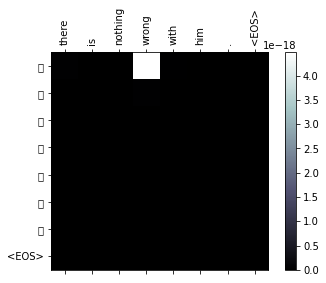

> they saw the sights of kyoto with their family .
= 彼 ら は 家族 と 一緒 に 京都 見物 を し た 。
< 私 は に の い い 。 <EOS>
bleu: 6.255495473556936e-232

/Users/m_ryo/.pyenv/versions/3.8.4/lib/python3.8/site-packages/matplotlib/textpath.py:84: RuntimeWarning: Glyph 12395 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
/Users/m_ryo/.pyenv/versions/3.8.4/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12395 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/m_ryo/.pyenv/versions/3.8.4/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12395 missing from current font.
  font.set_text(s, 0, flags=flags)


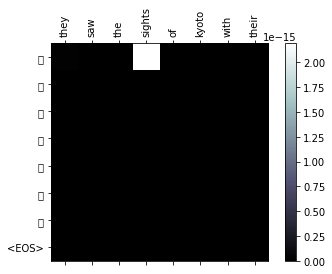

/Users/m_ryo/.pyenv/versions/3.8.4/lib/python3.8/site-packages/matplotlib/textpath.py:84: RuntimeWarning: Glyph 12383 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)
> divide it among the three .
= それ を ３ 人 の 間 で 分け よ 。
< 私 は は は に は た 。 <EOS>
bleu: 8.436497969708995e-232

/Users/m_ryo/.pyenv/versions/3.8.4/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 12383 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/m_ryo/.pyenv/versions/3.8.4/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 12383 missing from current font.
  font.set_text(s, 0, flags=flags)


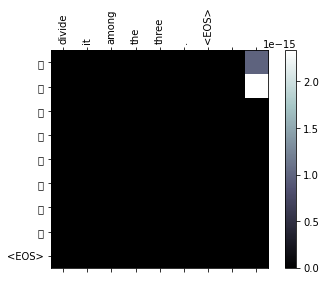

> she can speak english pretty well .
= 彼女 は かなり 上手 に 英語 を 話 す 。
< 私 は は の の い 。 <EOS>
bleu: 8.676910262183261e-232



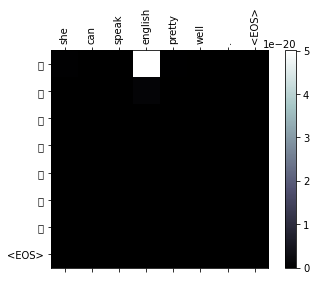

[7.107197028258987e-232,
 5.795035077445241e-155,
 6.255495473556936e-232,
 8.436497969708995e-232,
 8.676910262183261e-232]

In [13]:
evaluate_batch_randomly(seq2seq_lstm1_model, test_pairs, n=5)

In [14]:
MAX_LENGTH = 18

attn_size = 1024
decoder2 = AttnDecoderLSTM2(
                emb_size, hidden_size, attn_size, 
                output_lang.n_words, device)
decoder2.load_weights(
            load_m_dir=f'_logs/{load_model_dir}', 
            load_m_file_name='decoder_LSTM2.pth')

seq2seq_lstm2_model = Seq2Seq_batch_ptModel(
                            tokenizer, device,
                            dropout_p=0.1, max_length=MAX_LENGTH,
                            save_m_dir='_logs', 
                            save_m_file_names=(
                                'encoder.pth', 'decoder_LSTM2.pth'))
seq2seq_lstm2_model.set_models(encoder, decoder2)

[info] decoder_LSTM2.pth loaded !


> she is always at the bottom of the class .
= 彼女 は いつ も クラス のびり で あ る 。
< 私 は は は に い 。 <EOS>
bleu: 8.676910262183261e-232



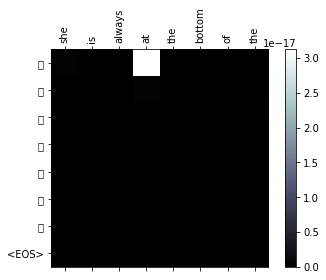

> she left early in the morning .
= 彼女 は 朝 早 く 出発 し た 。
< 私 は は は い 。 <EOS>
bleu: 8.396161215621529e-232



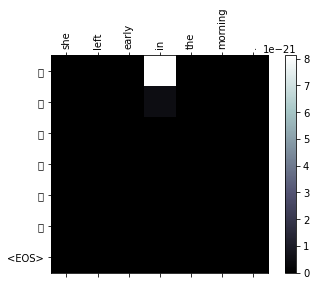

> are you having a good time ?
= 楽し く や っ て い ま す か 。
< 彼 は は は い 。 <EOS>
bleu: 7.107197028258987e-232



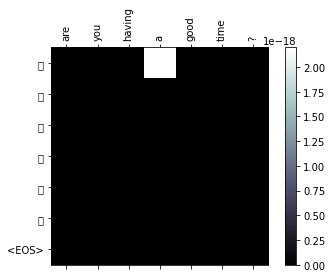

> he looked tired then .
= 彼 は その 時 疲れ て い る よう に 見え た 。
< 私 は は は の 。 <EOS>
bleu: 4.310732902257592e-232



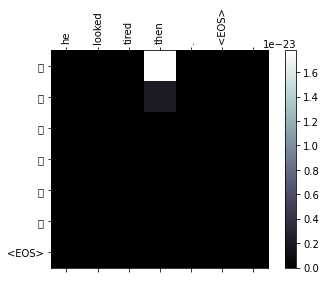

> he studied until two in the morning before the test .
= 彼 は テスト 前 は 、 午前 ２ 時 まで 勉強 し た 。
< 彼 は は の い 。 <EOS>
bleu: 2.376006315358735e-155



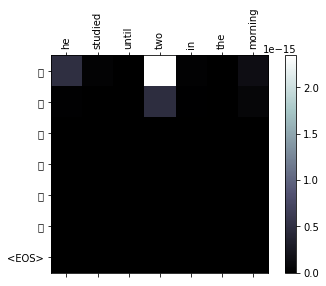

[8.676910262183261e-232,
 8.396161215621529e-232,
 7.107197028258987e-232,
 4.310732902257592e-232,
 2.376006315358735e-155]

In [15]:
evaluate_batch_randomly(seq2seq_lstm1_model, test_pairs, n=5)

In [16]:
# フォントを確認（日本語が入ると、文字化け（豆腐）になるかもなので）
# def show_avaiable_fonts():
#     print("Avaiable fonts:")
#     for font in mpl.font_manager.findSystemFonts():
#         fontname = mpl.font_manager.FontProperties(fname=font).get_name()
#         print(f"* {fontname}")

# # 利用可能なフォントを表示する。
# show_avaiable_fonts()

# !fc-list 

import matplotlib
# matplotlib.rcParams['font.family'] = 'IPAexGothic'
print(matplotlib.rcParams['font.family'])

['sans-serif']
